In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-20 16:18:07.757208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 1000)


,FAM50A (9130),CDK6 (1021),CDAN1 (146059),GPX4 (2879),SEPHS2 (22928),RAB6A (5870),SDHB (6390),AIFM1 (9131),SEPSECS (51091),GRB2 (2885),...,BTF3L4 (91408),NAA25 (80018),AMY2A (279),FOXO3B (2310),RBM12 (10137),EPC1 (80314),TBCE (6905),FZR1 (51343),TOMM20 (9804),PARN (5073)
0,0.094991,0.086944,0.199151,0.929326,0.010891,0.090511,0.010666,0.020907,0.264449,1.000000,...,0.955616,0.849532,0.241862,0.100542,0.001952,0.433017,0.148646,0.002767,0.621245,0.340925
1,0.718595,0.891492,0.979353,0.883257,0.406406,0.454668,0.336789,0.424902,0.347061,0.758245,...,0.566681,0.925048,0.474398,0.393359,0.061594,0.079709,0.838948,0.033079,0.896105,0.379185
2,0.328205,0.207870,0.979444,0.414971,0.054905,0.038188,0.625212,0.640939,0.028793,0.043139,...,0.310750,0.767096,0.410916,0.036441,0.813381,0.043596,0.858440,0.037557,0.247857,0.036056


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 1000)


,FAM50A (9130),CDK6 (1021),CDAN1 (146059),GPX4 (2879),SEPHS2 (22928),RAB6A (5870),SDHB (6390),AIFM1 (9131),SEPSECS (51091),GRB2 (2885),...,BTF3L4 (91408),NAA25 (80018),AMY2A (279),FOXO3B (2310),RBM12 (10137),EPC1 (80314),TBCE (6905),FZR1 (51343),TOMM20 (9804),PARN (5073)
0,0.358563,0.889037,0.956548,0.225670,0.032771,0.028074,0.134850,0.907241,0.028143,0.142124,...,0.673154,0.644727,0.678105,0.038979,0.081767,0.258632,0.407270,0.087389,0.743665,0.859452
1,1.000000,0.318987,0.999082,1.000000,0.999997,0.731645,0.996072,0.985970,0.999998,0.066652,...,0.715289,0.979737,0.488520,0.012557,0.170775,0.083500,0.610125,0.332838,0.955608,0.005067
2,0.292931,0.802980,0.999981,0.909353,1.000000,0.082395,0.113834,0.356964,0.895042,0.943140,...,0.879742,0.645630,0.849530,0.045784,0.008849,0.063486,0.095798,0.220030,0.150195,0.143480


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=70,
    batch_size=16,
    encoder_batch_norm=True,
    epochs=805, 
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=3,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-20 16:18:13.467878: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/805
49/49 [==============================] - 2s 19ms/step - loss: 711.1262 - recon: 605.0942 - kl: 106.0320 - val_loss: 566.5344 - val_recon: 517.0551 - val_kl: 49.4793
Epoch 2/805
49/49 [==============================] - 1s 18ms/step - loss: 646.6965 - recon: 543.7761 - kl: 102.9204 - val_loss: 547.3292 - val_recon: 469.1174 - val_kl: 78.2117
Epoch 3/805
49/49 [==============================] - 1s 20ms/step - loss: 592.1741 - recon: 491.4867 - kl: 100.6875 - val_loss: 556.1850 - val_recon: 439.7219 - val_kl: 116.4631
Epoch 4/805
49/49 [==============================] - 1s 16ms/step - loss: 543.4135 - recon: 444.8969 - kl: 98.5165 - val_loss: 520.5606 - val_recon: 381.4066 - val_kl: 139.1540
Epoch 5/805
49/49 [==============================] - 1s 11ms/step - loss: 507.0423 - recon: 410.0733 - kl: 96.9689 - val_loss: 491.3319 - val_recon: 352.8049 - val_kl: 138.5269
Epoch 6/805
49/49 [==============================] - 0s 6ms/step - loss: 468.9233 - recon: 373.3182 - kl: 95.6050 

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

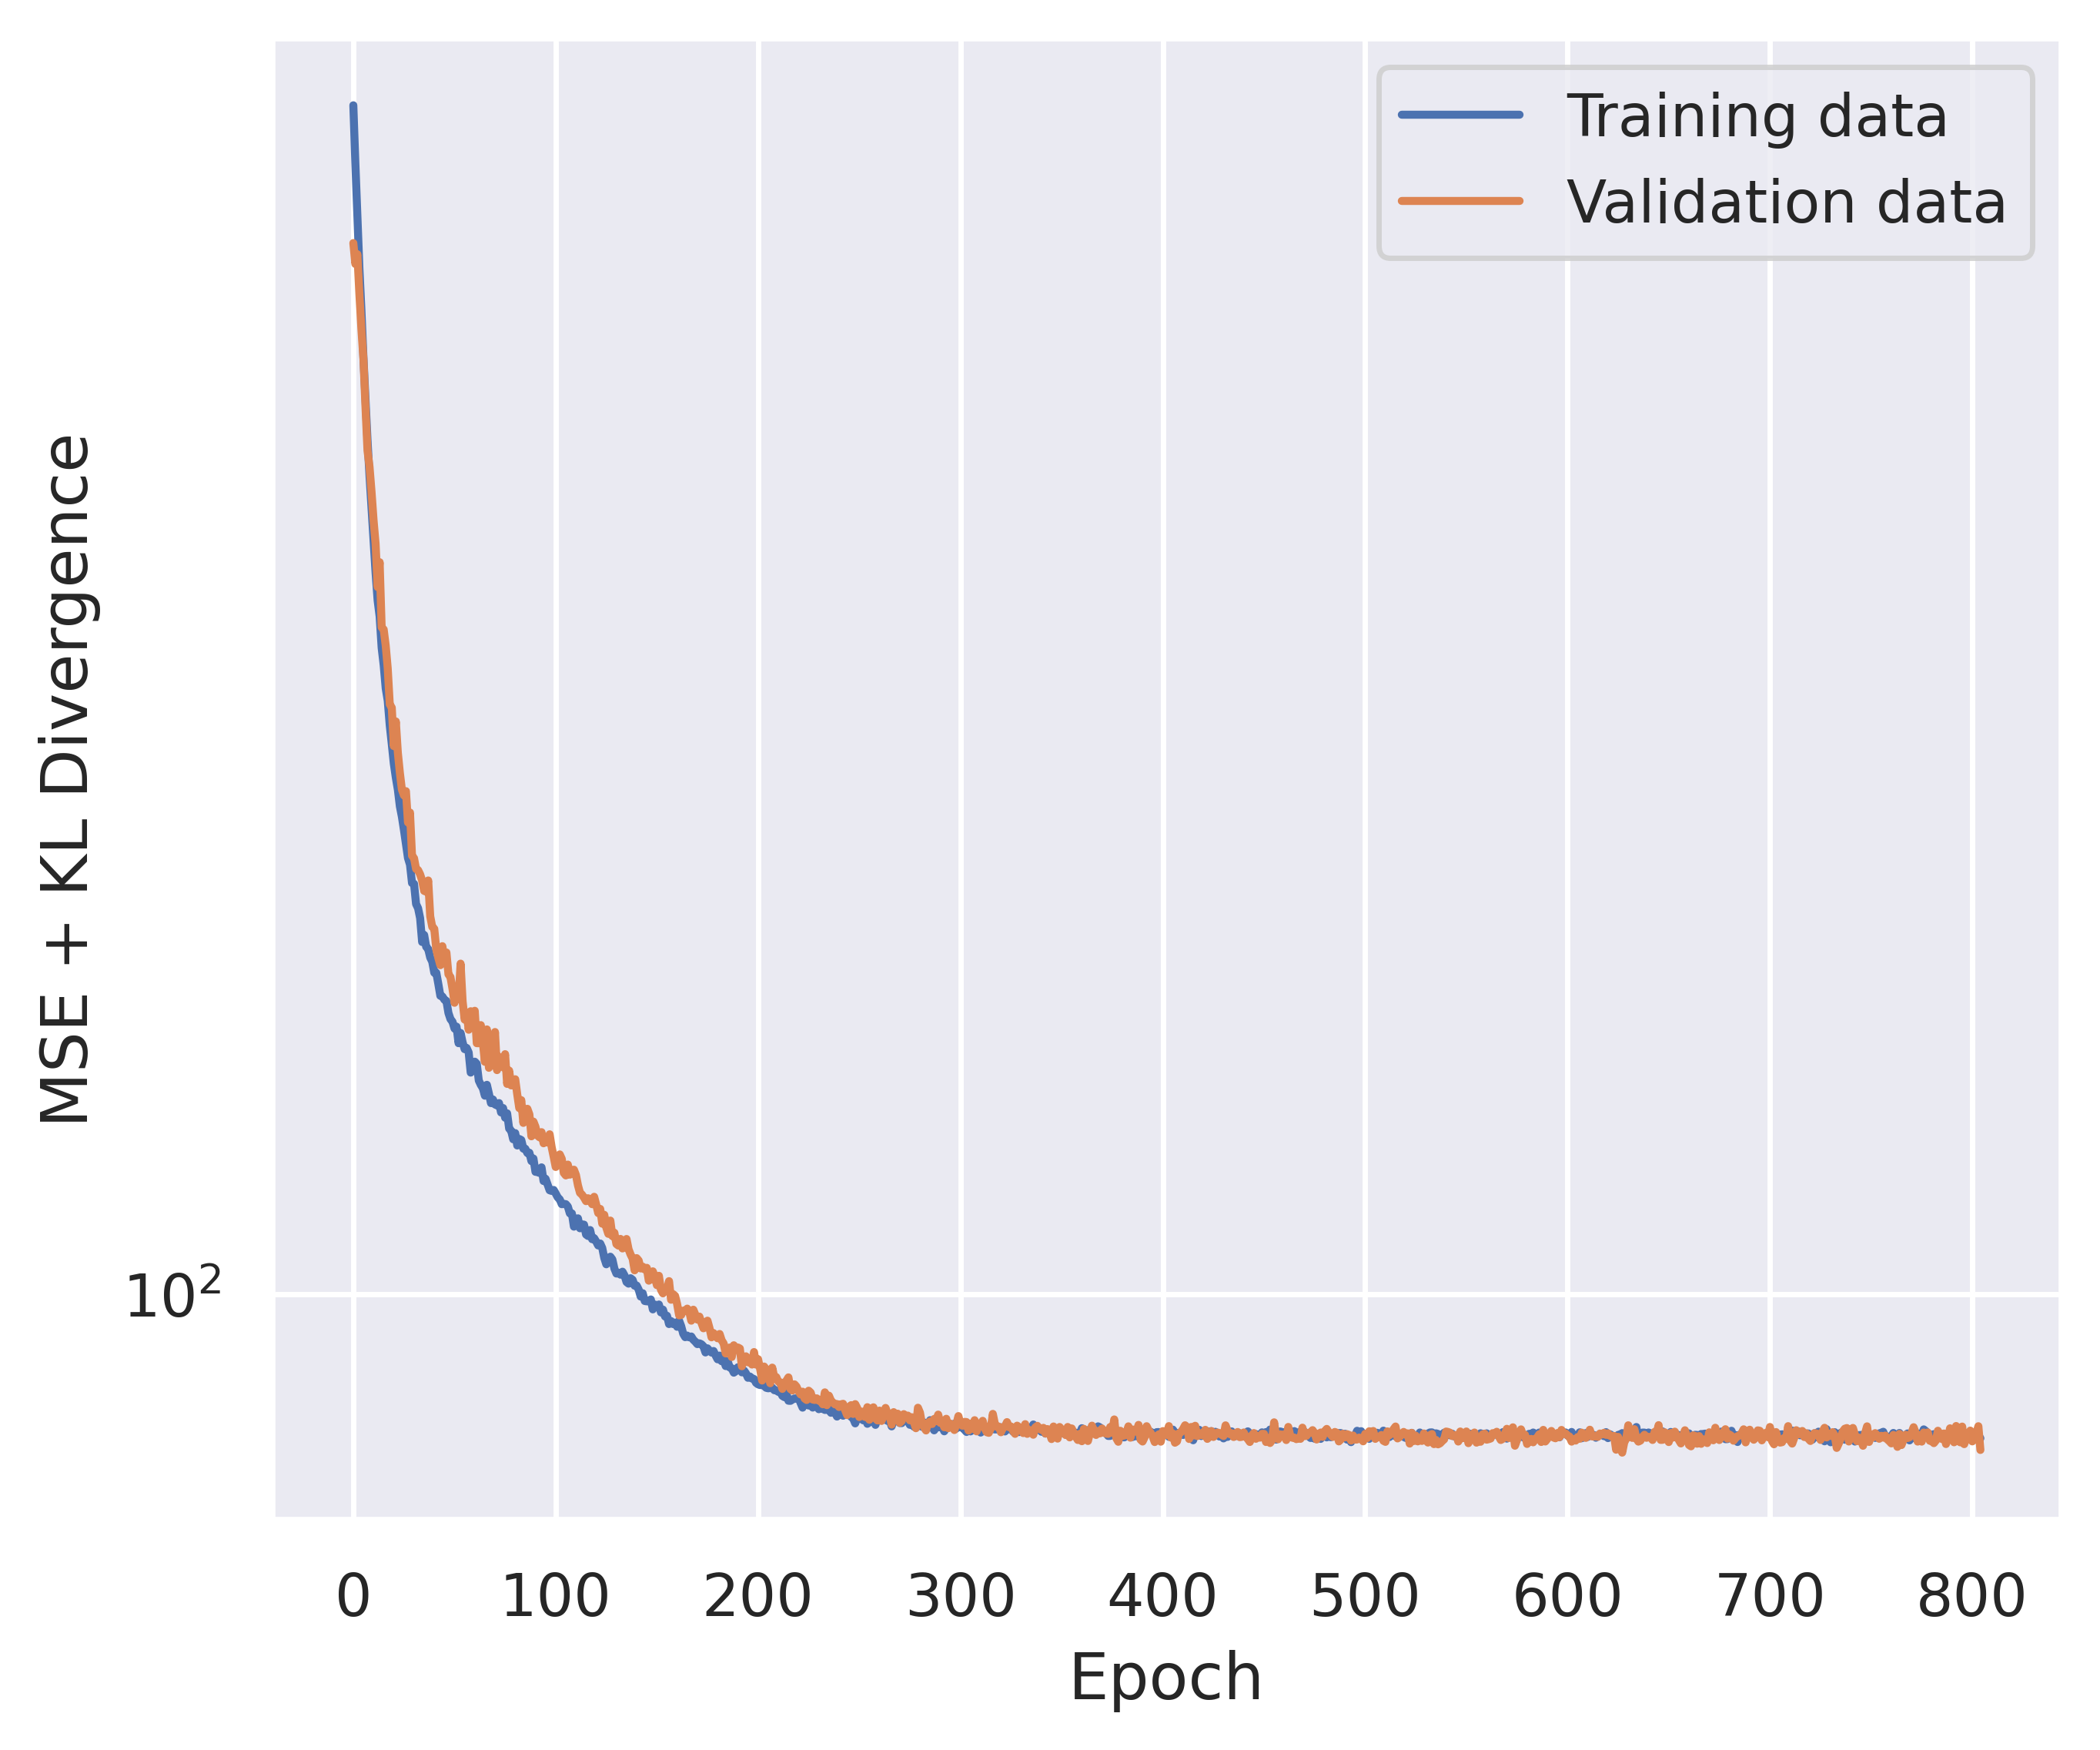

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)

metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata.to_csv(metadata_df_dir, index=False)
metadata


,ModelID,AgeCategory,Sex,train_or_test
0,ACH-002016,Adult,Female,train
1,ACH-002459,Adult,Male,train
2,ACH-002084,Adult,Female,train
3,ACH-000911,Adult,Male,train
4,ACH-002243,Adult,Female,train
...,...,...,...,...
907,ACH-001619,Adult,Male,test
908,ACH-001270,Pediatric,Male,test
909,ACH-000878,Adult,Male,test
910,ACH-000563,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 0s 7ms/step


,ModelID,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,ACH-002016,-0.184865,-0.411050,0.454746,-3.106170,0.996917,2.025824,0.128741,0.789501,-0.704711,...,1.013647,0.851004,-1.099368,1.276998,-0.734296,1.353215,0.105227,-0.353100,-0.109135,0.690944
1,ACH-002459,-0.841255,0.967951,-0.234476,-0.006460,-0.236287,-0.194632,0.713052,0.689127,1.828651,...,-1.329424,0.718433,-1.646360,0.798462,-1.527801,0.471166,-0.677441,1.965686,-0.539291,-0.636756
2,ACH-002084,-0.145864,1.285988,-2.011632,0.253741,0.411326,0.675839,0.749813,2.607659,-0.410942,...,0.910241,0.403596,-0.763382,-1.357188,0.693416,-0.384113,0.220602,1.108900,0.527525,0.628123
3,ACH-000911,-0.709051,2.570947,-0.621270,0.995376,1.026386,-0.127126,0.565364,3.134944,1.123284,...,-0.770088,-1.173011,-0.366723,0.493256,0.275975,0.190239,0.300456,-1.242162,0.374398,0.804870
4,ACH-002243,0.958294,0.273933,0.090853,0.175232,-0.983740,-1.329578,0.807019,1.022001,1.206007,...,0.483063,2.533804,-0.719492,0.484156,0.349337,0.196547,0.965003,0.365002,-1.586822,1.215492


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.065517,-0.032733,0.016796,-0.054844,0.036953,-0.050535,0.035076,0.007159,0.032103,-0.022363,...,0.067391,-0.024657,-0.012545,0.004022,0.009111,0.007209,0.038655,0.041393,-0.013804,0.034198
1,-0.002679,0.045508,0.031917,0.006865,-0.011732,-0.044319,-0.001106,-0.030111,-0.032521,-0.060816,...,-0.003756,-0.098214,-0.030270,0.029220,0.024960,-0.031610,-0.077953,-0.005751,-0.028775,-0.027772
2,-0.065351,-0.022536,0.002443,0.003644,-0.052182,0.003413,0.043525,-0.001345,0.041294,-0.059640,...,0.052262,-0.020468,-0.038528,0.019662,0.013879,-0.020691,0.019237,0.010507,-0.010602,0.025415
3,-0.051662,-0.011450,-0.063152,0.023219,0.004973,0.056593,0.018017,-0.054374,-0.011835,-0.080668,...,0.005306,-0.060739,-0.045656,-0.001605,-0.040403,-0.023258,-0.043615,-0.081619,-0.029048,-0.069127
4,-0.013521,-0.010980,-0.004323,0.046486,-0.047013,0.034360,-0.049736,0.044843,-0.027027,0.004495,...,-0.012993,-0.016999,-0.053929,0.027880,0.047067,0.017589,-0.057068,-0.060426,-0.073335,-0.057183


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,FAM50A,-0.065517,-0.032733,0.016796,-0.054844,0.036953,-0.050535,0.035076,0.007159,0.032103,...,0.067391,-0.024657,-0.012545,0.004022,0.009111,0.007209,0.038655,0.041393,-0.013804,0.034198
1,CDK6,-0.002679,0.045508,0.031917,0.006865,-0.011732,-0.044319,-0.001106,-0.030111,-0.032521,...,-0.003756,-0.098214,-0.030270,0.029220,0.024960,-0.031610,-0.077953,-0.005751,-0.028775,-0.027772
2,CDAN1,-0.065351,-0.022536,0.002443,0.003644,-0.052182,0.003413,0.043525,-0.001345,0.041294,...,0.052262,-0.020468,-0.038528,0.019662,0.013879,-0.020691,0.019237,0.010507,-0.010602,0.025415
3,GPX4,-0.051662,-0.011450,-0.063152,0.023219,0.004973,0.056593,0.018017,-0.054374,-0.011835,...,0.005306,-0.060739,-0.045656,-0.001605,-0.040403,-0.023258,-0.043615,-0.081619,-0.029048,-0.069127
4,SEPHS2,-0.013521,-0.010980,-0.004323,0.046486,-0.047013,0.034360,-0.049736,0.044843,-0.027027,...,-0.012993,-0.016999,-0.053929,0.027880,0.047067,0.017589,-0.057068,-0.060426,-0.073335,-0.057183
